# Learning Procedure Demo Notebook
This notebook is a step-by-step illustration of the sparse pauli model learning procedure.

In [53]:
#Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer, AerSimulator
from random import random

#python imports
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np

plt.style.use("ggplot")

## Setup
The procedure takes as input the layer whose associated noise will be learned in the variable `layer`. This layer should include only the noisy gates and context qubits to be benchmarked. The variable `inst_map` stores the indices in order of the layer qubits on the physical hardware. The variable `backend` is required to extract the coupling map.

In [54]:
backend = FakeVigoV2()
inst_map = [0,1]
n = len(inst_map)
layer = QuantumCircuit(n)
layer.cx(0,1)

## Determination of measurement bases
The following cell determines the nine Pauli bases used to make measurements simultaneously. It uses the coupling map from `backend` in conjuction with the procedure described in van den Berg. The output is an array of nine Pauli operators where `inst_map` determines the qubits that correspond to the terms in the Paulis.

In [55]:
NUM_BASES = 9

bases = [['I']*n for i in range(NUM_BASES)]
connectivity = backend.coupling_map.graph.subgraph(inst_map)

for vertex in range(n):
    #copied from Fig. S3 in van den Berg
    orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                        "XXXYYZZZY":"XYZXYZXYZ",
                        "XXYYYZZZX":"XYZXYZXYZ",
                        "XXZYYZXYZ":"XYZXZYZYX",
                        "XYZXYZXYZ":"XYZZXYYZX"}
    
    children = connectivity.neighbors(vertex)
    predecessors = [c for c in children if c < vertex]

    match len(predecessors):
        #trivial if no predecessors
        case 0:
            cycp = cycle("XYZ")
            for i,_ in enumerate(bases):
                bases[i][vertex] = next(cycp)
        #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
        case 1:
            pred, = predecessors
            #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
            _,bases = list(zip(*sorted(zip([p[pred] for p in bases], bases))))
            cycp = cycle("XYZ")
            for i,_ in enumerate(bases):
                bases[i][vertex] = next(cycp)
        case 2:
            pred0,pred1 = predecessors
            _,bases = list(zip(*sorted(zip([p[pred0] for p in bases], bases))))
            #list out string with permuted values of predecessor 2
            substr = [p[pred0] for p in bases]
            #match predecessor two with a permutation of example_orderings
            reordering = ""
            for perm in permutations("XYZ"):
                substr = "".join(["XYZ"[perm.index(p)] for p in substr])
                if substr in orderings:
                    current = orderings[substr] 
                    for i,p in enumerate(current):
                        bases[i][vertex] = p
                    break
        case _: #processor needs to have connectivity so that there are <= 2 predecessors
            raise Exception("Three or more predecessors encountered")
    print(len(predecessors), bases)

print("Pauli basis:", ["".join(b) for b in bases])
bases = [Pauli("".join(string[::-1])) for string in bases]

0 [['X', 'I'], ['Y', 'I'], ['Z', 'I'], ['X', 'I'], ['Y', 'I'], ['Z', 'I'], ['X', 'I'], ['Y', 'I'], ['Z', 'I']]
1 (['X', 'X'], ['X', 'Y'], ['X', 'Z'], ['Y', 'X'], ['Y', 'Y'], ['Y', 'Z'], ['Z', 'X'], ['Z', 'Y'], ['Z', 'Z'])
Pauli basis: ['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


## Generate the Sparse Model
This next cell again uses the coupling map from `backend` to find the pauli terms in the sparse model. A set is used because the coupling map is bidirectional.

In [56]:
model_terms = set()
identity = Pauli("I"*n)
#get all weight-two paulis on with suport on nieghboring qubits
for q1,q2 in connectivity.edge_list():
        for p1, p2 in pauli_basis(2):
            pauli = identity.copy()
            pauli[q1] = p1
            pauli[q2] = p2
            model_terms.add(pauli)

model_terms.remove(identity)
model_terms = list(model_terms)
print("Model terms:", [m.to_label()[::-1] for m in model_terms])

Model terms: ['ZZ', 'ZX', 'ZI', 'YY', 'XZ', 'XY', 'IZ', 'YZ', 'XI', 'ZY', 'XX', 'YX', 'IY', 'IX', 'YI']


The simulator refuses to simulate Pauli instructions that include a global phase, even though there is no clear reason for this. The `nophase` method is used to remove the phase from an operator. The `conjugate` method returns the conjugation of an Pauli operator by the layer.

In [57]:
#remove the phase from a Pauli
def nophase(pauli):
    return Pauli((pauli.z, pauli.x))

def conjugate(pauli):
    return nophase(pauli.evolve(layer))

In [58]:
#print(Pauli("IX").commutes(Pauli("XX")))
p = Pauli("YX")

layer = QuantumCircuit(2)
layer.cnot(0,1)


def conjugate(pauli):
    return nophase(pauli.evolve(layer))
print(conjugate(p))

ZY


## Generate circuit instances for learning
The following method performs the following function:
* Compose $B_a$ gates to prepare Pauli operator $P_a$
* Add $n$ layers of twirl and repetitions of noisy layer
* Invert the pauli frame, and compose $B_b^\dagger$ and readout gates into last layer

The method takes as input the preparation and measurement bases (which can be different for the single measurements), the number of repetitions of the noisy layer, and an optional `transpiled` variable to help with debugging.

In [59]:
def instance( 
    prep_basis : Pauli, 
    meas_basis : Pauli, 
    noise_repetitions : int, 
    transpiled=True):

    circ = QuantumCircuit(n) #storing the final circuit

    #get preparation ops from desired basis 
    def prep(basis, qubit, qc):
        if basis.equiv(Pauli("X")):
            qc.h(qubit) 
        elif basis.equiv(Pauli("Y")):
            qc.h(qubit)
            qc.s(qubit)

    #apply operators to a quantum circuit to measure in desired pauli basis
    def meas(basis, qubit, qc):
        if basis.equiv(Pauli("X")):
            qc.h(qubit)
        elif basis.equiv(Pauli("Y")):
            qc.sdg(qubit)
            qc.h(qubit)


    pauli_frame = Pauli("I"*n)

    #apply the prep and twirling operators to the circuit
    for q,b in enumerate(prep_basis):
        prep(b,q,circ)

    circ.barrier()

    #apply repetitions of noise, including basis-change gates when needed
    for i in range(noise_repetitions):

        twirl = Pauli("".join(choices("IXYZ", k=n)))
        pauli_frame = pauli_frame.compose(twirl)
        pauli_frame = conjugate(pauli_frame)

        for i,p in enumerate(twirl):
            circ.append(p, [i])

        circ = circ.compose(layer)
        circ.barrier()

    #choose sstring of bit flips for readout twirling
    rostring = "".join(choices(['I','X'], k=n))
    for i,p in enumerate(pauli_frame):
        circ.append(p, [i])
    circ.barrier()
    for q,(b,r) in enumerate(zip(meas_basis, rostring)):
        meas(b, q, circ)
        if r == "X":
            circ.x(q)

    circ.measure_all()

    if transpiled:
        circ = transpile(circ, backend, inst_map=inst_map, optimization_level = 1) #this could be fixed

    circ.metadata = {
        "prep_basis":prep_basis,
            "meas_basis":meas_basis, 
            "depth":noise_repetitions, 
            "rostring":rostring[::-1],
            }

    return circ 

In [60]:
instance(Pauli("XY"), Pauli("XY"),2,transpiled=False).draw()

┌───┐┌───┐ ░ ┌───┐      ░ ┌───┐      ░ ┌───┐ ░ ┌─────┐┌───┐┌───┐ ░ ┌─┐»
   q_0: ┤ H ├┤ S ├─░─┤ Y ├──■───░─┤ Y ├──■───░─┤ Z ├─░─┤ Sdg ├┤ H ├┤ X ├─░─┤M├»
        ├───┤└───┘ ░ ├───┤┌─┴─┐ ░ ├───┤┌─┴─┐ ░ ├───┤ ░ └┬───┬┘├───┤└───┘ ░ └╥┘»
   q_1: ┤ H ├──────░─┤ I ├┤ X ├─░─┤ Y ├┤ X ├─░─┤ Z ├─░──┤ H ├─┤ X ├──────░──╫─»
        └───┘      ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘ ░  └───┘ └───┘      ░  ║ »
meas: 2/════════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«           
«   q_0: ───
«        ┌─┐
«   q_1: ┤M├
«        └╥┘
«meas: 2/═╩═
«         1

In [61]:
instance(Pauli("XY"), Pauli("XY"),2,transpiled=False).copy_empty_like().draw()

q_0: 
        
   q_1: 
        
meas: 2/

### Get expectation value from single instance

The following method is used to parse a `Counts` object. The readout result is flipped by the readout twirling, the specific choice of which is recovered from the circuit metadata. Then the overlap with the Pauli being measured in the computational basis is computed.

In [62]:
{'10': 238, '11': 7, '01': 4, '00': 1}
(238+4-7-1)/250 #0.936

0.936

In [63]:
def get_expectation(pauli, **metadata):
        estimator = 0
        counts = metadata['counts']
        rostring = metadata['rostring']
        #compute locations of non-idetity terms (reversed indexing)
        pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
        #compute estimator
        for key in counts.keys():
            #untwirl the readout
            ro_untwirled = [{'0':'1','1':'0'}[bit] if flip=="X" else bit for bit,flip in zip(key,rostring)]
            #compute the overlap in the computational basis
            sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, ro_untwirled)])
            #print(sgn)
            #update estimator
            estimator += (-1)**sgn*counts[key]

        #print(counts)
        #print(estimator/sum(counts.values()))
        return estimator/sum(counts.values())

### Test noise model generation
A test noise model is used to compare the efficacy of the procedure against known values. This is done by randomly choosing values for different pauli operators to create a random pauli noise model. A better way to do this would be to incorporate a non-pauli channel so that the twirl can be tested, but the diagonalization of the twirl can also be verified on the non-Pauli noise model of the simulator.

In [64]:
sim = Aer.get_backend('qasm_simulator') #initialize simulator

The noise model needs to have the biggest discrepancy possible between different fidelities. This could be accomplished by adjusting the fidelities directly, but since the model is random, this way works as well. `num` determines the number of different errors that are simulated. There was no motivation for choosing the value `.1.` to multiply the error probability other than creating errors that seemed physically realistic.

In the actual procedure, the noise of dressed cycles will be learned, which includes the twirl. Here, there is no single-qubit noise simulated, because in the simulation it introduces a significant amount of SPAM noise, specifically state preparation noise, and it is hard to make accurate predictions about the result. 

Text(0, 0.5, '10 x (1-f)')

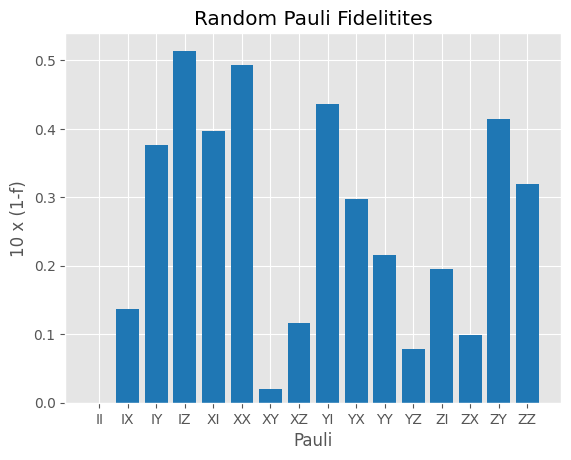

In [65]:
num = 4  #number of errors
errorops = choices(pauli_basis(2), k=num) #choose random pauli errors
errorprobs = [random()*.1/num for op in errorops] #assign random probabilities
#create normalized error model
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data #Find out more about this
for i,pauli in enumerate(pauli_basis(2)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real, color="tab:blue")

plt.title("Random Pauli Fidelitites")
plt.xlabel("Pauli")
plt.ylabel("10 x (1-f)")

## Example tomography procedure
The next few cells give an example of tomography of a single fidelity using the methods above.

### Collect data

In [66]:
depths = [0,2,4,8,16,32] #levels of noise repetition
results = []
samples = 32 #number of samples to take from twirl
shots = 250
pauli = Pauli("YY") #pauli pair to measure
for d in depths:
    result = 0
    for t in range(samples):
        circ = instance(pauli, pauli,d,transpiled=False) #generate instance
        #the circ generation here could be improved, by pass by value
        counts = sim.run(circ, shots = shots, noise_model = noise_model).result().get_counts() #get counts
        result += get_expectation(pauli, counts = counts, rostring = circ.metadata['rostring']) #compute expectation
        print("depth:", d,"samples:",t+1, end='\r')
    results.append(result/samples)

### Perform fit

In [67]:
expfit = lambda x,a,b: a*np.exp(-b*x)
popt, pcov = curve_fit(expfit, depths, results, p0=[.9,.01])
print("measured pair:",np.exp(-popt[1]), "ideal pair:", np.sqrt(real_errors[pauli]*real_errors[conjugate(pauli)]).real)

measured pair: 0.9842259794855979 ideal pair: 0.9842212573922261


### Graph result

Text(0.5, 0, 'Noise repetitions')

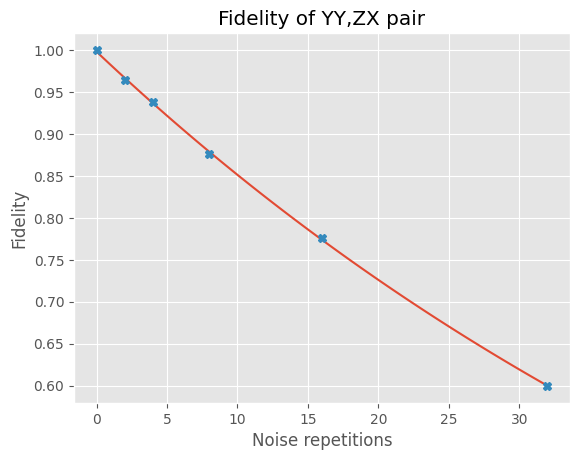

In [68]:
xrange = np.linspace(0,np.max(depths),100)
plt.plot(xrange,[expfit(x,*popt) for x in xrange])
plt.plot(depths,results, "X")
plt.title("Fidelity of "+pauli.to_label()+","+conjugate(pauli).to_label()+ " pair")
plt.ylabel("Fidelity")
plt.xlabel("Noise repetitions")

## Full Procedure
The code below shows how all of the measurements can be carried out together and the results processed to obtain the noise model.

### Simultanous single measurements
First, there is a degeneracy in the model. The intuition for this is a degeneracy is created if a pair appears twice. This causes $M$ to have two duplicate columns, which results in a non-invertible matrix. A pair appears twice whenever a pauli and its pair are non-equal and both appear in the sparse model.

The degeneracy-lifting measurements can be made with only six different basis. This is because terms with support on disjoint gates don't affect eachother, and therefore can be measured simultaneously. There are two single-weight Paulis on each gate which are stablized by the Clifford, leaving four single-weight Pauli terms that require measurements. In addition, there are two weight-two Pauli terms requiring degeneracy lifting. This is where I ran into issues with choosing the single-qubit gates, but these two extra measurements do not affect the complexity of the procedure or theoretically the accuracy of the result either unless more than two points are used for the exponential fit.

In [69]:
def weight(pauli):
    return len([p for p in pauli if not p==Pauli("I")])

#return True if Paulis differ by "I"s only
def disjoint(pauli1, pauli2):
    return all([p1==p2 or (p1 == Pauli("I") or p2 == Pauli("I")) for p1,p2 in zip(pauli1, pauli2)])

#return True if pauli requires a degeracy lifting measurement based on the conditions described above
def requires_single(pauli):
    pair = conjugate(pauli)
    return (pauli in model_terms and pair in model_terms) and pauli != pair

#find disjoint operators that can be measured simultaneously to find six bases
#print(model_terms)
pairs = set([frozenset([p,conjugate(p)]) for p in model_terms if requires_single(p)])
#print(pairs, len(pairs))
single_bases = []
for p1,p2 in pairs:
    for i,pauli in enumerate(single_bases):
        if disjoint(pauli, p1) and disjoint(pauli, p2):
            single_bases[i] = nophase(pauli.compose(p2)) #Why do we do this here?
            break
    else: #why is this else here? this doesn't do anything
        single_bases.append(p2)

print("bases for singles: ",single_bases)

bases for singles:  [Pauli('ZZ'), Pauli('ZX'), Pauli('ZY'), Pauli('IX'), Pauli('XY'), Pauli('YZ')]


In [70]:
pauli1 = Pauli("YZ")
pauli2 = Pauli("YI")
print([(p, conjugate(p)) for p in model_terms if not requires_single(p)])
print(pairs)
print(model_terms)

[(Pauli('XZ'), Pauli('XZ')), (Pauli('IZ'), Pauli('IZ')), (Pauli('XI'), Pauli('XI'))]
{frozenset({Pauli('ZI'), Pauli('ZZ')}), frozenset({Pauli('YY'), Pauli('ZX')}), frozenset({Pauli('YX'), Pauli('ZY')}), frozenset({Pauli('XX'), Pauli('IX')}), frozenset({Pauli('IY'), Pauli('XY')}), frozenset({Pauli('YI'), Pauli('YZ')})}
[Pauli('ZZ'), Pauli('XZ'), Pauli('IZ'), Pauli('YY'), Pauli('ZX'), Pauli('YX'), Pauli('ZI'), Pauli('ZY'), Pauli('IX'), Pauli('YZ'), Pauli('XX'), Pauli('XY'), Pauli('YI'), Pauli('XI'), Pauli('IY')]


### Generate circuits
This cell generates the required number of samples at different depths using the nine pauli bases and the single degeneracy-lifting measurements in the six bases computed above.

In [71]:
SINGLE = 1
circuits = []
depths = [2,4,8,16]
samples = [32]*len(depths)
single_samples = 250
total = len(bases)*sum(samples)+len(single_bases)*single_samples

j=0
for basis, (d,s) in product(bases, zip(depths,samples)): #samples here is completely unnessesary. It only exists for the calculation of "total"
    for i in range(s):
        circ = instance(basis, basis, d)
        circ.metadata["type"] = "double"
        circuits.append(circ)

        j+=1
        print(j,"/",total, end='\r')

for basis, s in product(single_bases, range(single_samples)):
    #print(basis, conjugate(basis))
    circ = instance(conjugate(basis),basis,SINGLE)
    circ.metadata["type"] = "single"
    circuits.append(circ)

    j+=1
    print(j,"/",total, end='\r')

/tmp/ipykernel_1923/2649491544.py:60: DeprecationWarning: Passing in a list of arguments for inst_map is deprecated and will no longer work starting in the 0.25.0 release.
  circ = transpile(circ, backend, inst_map=inst_map, optimization_level = 1) #this could be fixed


In [72]:
print(circuits[0])

global phase: π
               ┌─────────┐┌────┐┌─────────┐ ░ ┌────────┐┌───┐      ░   ┌───┐   »
      q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(-π) ├┤ X ├──■───░───┤ X ├───»
               ├─────────┤├────┤├─────────┤ ░ ├───────┬┘└───┘┌─┴─┐ ░ ┌─┴───┴──┐»
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(π) ├──────┤ X ├─░─┤ Rz(-π) ├»
               └─────────┘└────┘└─────────┘ ░ └───────┘      └───┘ ░ └────────┘»
ancilla_0 -> 2 ────────────────────────────────────────────────────────────────»
                                                                               »
ancilla_1 -> 3 ────────────────────────────────────────────────────────────────»
                                                                               »
ancilla_2 -> 4 ────────────────────────────────────────────────────────────────»
                                                                               »
       meas: 2/════════════════════════════════════════════════════════════════»
            

### Get results
Once the circuits are generated, they can be submitted as an array in no particular order directly to the processor

In [73]:
results = sim.run(circuits, shots=1000, noise_model = noise_model).result().get_counts()

## Analysis
The cells below show the anlysis of the data obtained from a run of the procedure.

The `sim_meas` method below determines how many model terms can be measured simultaneously given a basis.

In [74]:
#Shows whether two pauli operators can be measured simultaneously
def simultaneous(pauli1, pauli2):
    return all([p1==p2 or p2 == Pauli("I") for p1,p2 in zip(pauli1, pauli2)])

#Gives a list of all terms in the model that can be measured simultaneously with pauli
def sim_meas(pauli):
    return [term for term in model_terms if simultaneous(pauli, term)]

#Gives a list of all terms, in the sparse model or not, that can be measured simultaneously
#This is used to overdeteremine the model, but since it grows as 2^n, this method can always be
#replaced with sim_meas
def all_sim_meas(pauli):
    return [Pauli("".join(p)) for p in product(*zip(pauli.to_label(), "I"*n))]
#all_sim_meas = sim_meas

Sort the run data into singles and doubles measurements, becuase each require slightly different analysis procedures.

In [75]:
#Sort into single and double measurements
for res,circ in zip(results, circuits):
    circ.metadata["counts"] = res

singles = []
doubles = []
for circ in circuits:
    datum = circ.metadata
    type = datum["type"]
    datum.pop("type")
    if type == "single":
        singles.append(datum)
    elif type == "double":
        doubles.append(datum)

Restructure data into `basis_dict` as a dictionary whose keys are model terms containing the expectation value taken at each depth, the preparation and measurement basis, and the total number of measurements that were made (included because single-weight are measured with multiple bases)

In [76]:
#reorder by measurement basis
basis_dict = {}
#improve execution time by storing runs of all_sim_meas for each basis
sim_measurements = {}
for datum in doubles:
    #get run data
    basis = datum['prep_basis']
    depth = datum['depth']
    #find simultaneous measurements
    if not basis in sim_measurements:
        sim_measurements[basis] = all_sim_meas(basis)
    #aggregate expectation value data for each simultaneous measurement
    for pauli in sim_measurements[basis]:
        expectation = get_expectation(pauli, **datum)
        #set up dictionary
        if not pauli in basis_dict:
            basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
        #add expectation value to result at depth
        basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
        basis_dict[pauli]["total"][depths.index(depth)] += 1

Use curve-fits to determine all fidelity pairs and extract SPAM coefficients from the intercepts of the fits.

In [77]:
expfit = lambda x,a,b : a*np.exp(x*-b)
#for each of the simultaneous measurements
for key in basis_dict.keys(): #key is here the same as pauli in block above
    for i,d in enumerate(depths):
        #divide by total
        basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
    #try finding exponential fit, default to ideal if no fit found
    try:
        popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
    except:
        popt = 1,0

    #store fidelity and SPAM coefficients
    basis_dict[key]["fidelity"] = expfit(1,1,popt[1]) # could put this line in the if below because singles don't use this ever
    basis_dict[key]["SPAM"] = popt[0] #find out more about this

    #record whether measurement appears as a pair or as a single fidelity
    if key != conjugate(key): #Same as is_single
        basis_dict[key]["type"] = "pair" #denote if the value is "sqrt(f^dagger*f)"
    else:
        basis_dict[key]["type"] = "single" #of if it is just f

Aggregate the results of the simultanous single measurements to lift the degeneracy in the model

In [78]:
singles_dict = {} #store results of single measurements
sim_measurements = {}
for datum in singles:
    meas_basis = datum['meas_basis']
    prep_basis = datum['prep_basis']
    #find terms that can be measured simultaneously
    if not meas_basis in sim_measurements:
        sim_measurements[meas_basis] = []
        for term in model_terms:
            if simultaneous(meas_basis, term) and simultaneous(prep_basis, conjugate(term)) and requires_single(term):
                sim_measurements[meas_basis].append(term)
    #aggregate data together
    for meas in sim_measurements[meas_basis]:
        if meas not in singles_dict:
            singles_dict[meas] = 0
        expectation = get_expectation(meas, **datum)
        #the measurement basis SPAM coefficients are closer because the readout noise, combined
        #with the noise from the last layer, is greater than the state preparation noise
        fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas]["SPAM"]])
        singles_dict[meas] += fidelity/single_samples

#add singles data to basis_dict
for key in singles_dict.keys():
    basis_dict[key]['fidelity'] = singles_dict[key]
    basis_dict[key]['type'] = "single"

## Results

In [79]:
#graph a subset of the measured expectation values and plot fits
def graph(*paulis):
    colcy = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:cyan", "tab:brown", "tab:pink", "tab:gray", "tab:olive"])
    for p in paulis:
        c = next(colcy)
        data = basis_dict[p]['expectation']
        popt, pcov = curve_fit(expfit, depths, data, p0=[.9,.01])
        xrange = np.linspace(0,np.max(depths))
        plt.plot(xrange, [expfit(x, *popt) for x in xrange], color=c)
        plt.plot(depths, data, color = c, marker="o", linestyle = 'None')
    plt.title("Expectation vs Depth")
    plt.xlabel("Depth")
    plt.ylabel("Fidelity")

#display the measured fidelities plotted against the ideal fidelitites
def display(*paulis):
    ax = np.arange(len(paulis))
    fidelities = []
    fidelities_calculated = []
    for p in paulis:
        fid = basis_dict[p]['fidelity']
        if(basis_dict[p]['type'] == 'pair'):
            pair = conjugate(p)
            fid = fid**2/basis_dict[pair]['fidelity']
        fidelities.append(fid)
        fidelities_calculated.append(real_errors[p])
    plt.bar(ax+.2, [10*(1-f) for f in fidelities], .4,color='tab:blue')
    plt.bar(ax-.2, [10*(1-f) for f in fidelities_calculated],.4, color='tab:green')
    plt.xticks(ax, paulis)
    plt.title("Measured vs Actual Fidelitites")
    plt.xlabel("Term")
    plt.ylabel("10 x (1-f)")
    plt.legend(["Measured", "Ideal"])

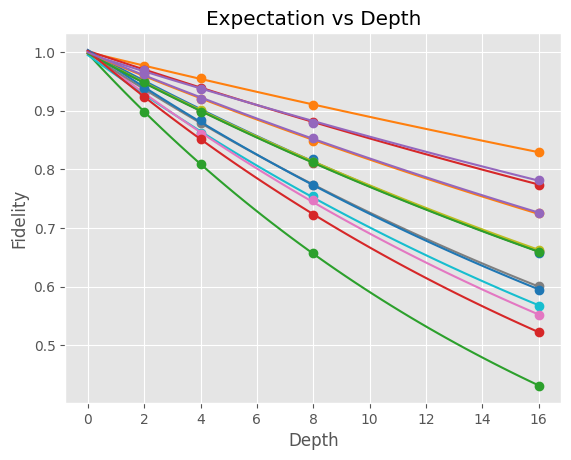

In [80]:
graph(*model_terms)


/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


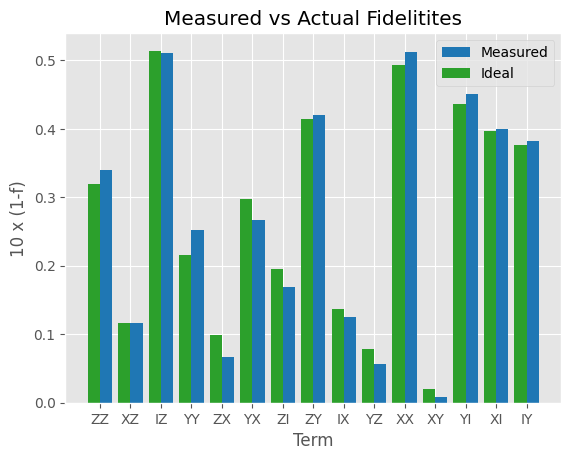

In [81]:
display(*model_terms)

### Learn model terms
The lists $F_1$ and $F_2$ can be constructed in the following way: First, $F_1$ is chosen to be $F$, the set of sparse model terms. The list $F_2$ is chosen to be the same as $F_1$ if the single fidelity is known, and changes to the conjugate fidelity if a pair is known.

In [82]:
f1 = []
f2 = []
fidelities = []
for key in model_terms:
    f1.append(key)
    fidelities.append(basis_dict[key]['fidelity'])
    if basis_dict[key]["type"] == "pair":
        pair = conjugate(key)
        f2.append(pair)
    else: #here is single
        f2.append(key)

Construct the matrices $M_1$ and $M_2$

In [83]:
sprod = lambda a,b: int(a.anticommutes(b))
M1 = [[sprod(a,b) for a in model_terms] for b in f1]
M2 = [[sprod(a,b) for a in model_terms] for b in f2]

The matrix should be full rank

In [84]:
np.linalg.matrix_rank(np.add(M1,M2)) == len(model_terms)

True

Since the vector of fidelitites $\vec f$ is either $f_a$ or $\sqrt{f_a'f_a}$, the equation for calculating the model terms is
$$
(M_1+M_2)\vec \lambda+\log(\vec f) = 0
$$
The equation for calculating the model terms using single fidelities is the same as the original:
$$
M\vec \lambda + \frac{1}{2}\log(\vec f) = 0
$$

In [85]:
coeffs,rnorm = nnls(np.add(M1,M2), -np.log([f.real for f in fidelities]))
real_coeffs, real_rnorm = nnls(M1, -.5*np.log([real_errors[term].real for term in f1]))

One thing to note is that the graph in van den Berg et Al. doesn't plot the actual coefficients vs ideal coefficients, but simply the goodness of fit using nnls

Text(0, 0.5, 'Coefficient')

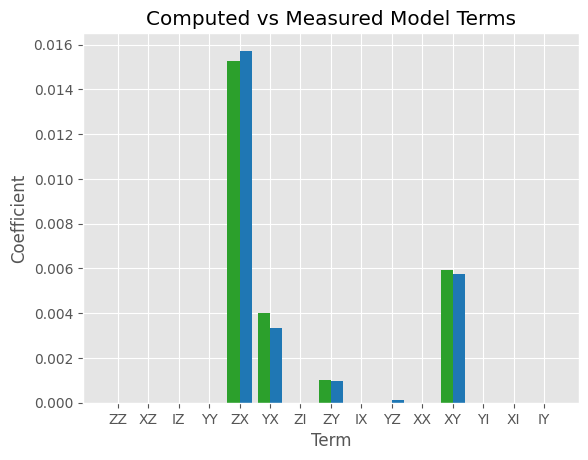

In [86]:
ax = np.arange(len(model_terms))
plt.bar(ax+.2, coeffs, .4, color='tab:blue')
plt.bar(ax-.2, real_coeffs, .4, color='tab:green')
plt.xticks(ax, model_terms);
plt.title("Computed vs Measured Model Terms")
plt.xlabel("Term")
plt.ylabel("Coefficient")